## Perhaps missing data should be dealt with first to fill in gaps before imputing zeros

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dbhelper import pd_query

In [56]:
target_query = '''
               select 
                   d.date,
                   year,
                   month,
                   dayofmonth,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime,
                   valid
               from datefeatures d
               left join crossingdata c
                   on d.date = c.date
               left join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=2
                order by d.date;
               '''

df = pd_query(target_query)
df = df.set_index('date')

## Where is missing data?
Focus on data after 2012

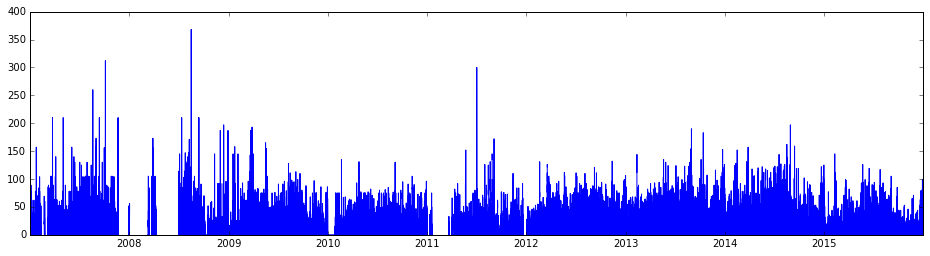

In [57]:
plt.figure(figsize=(16,4))
plt.plot(df.waittime);

In [59]:
target_query = '''
               select 
                   d.date,
                   year,
                   month,
                   dayofmonth,
                   week,
                   dayofweek,
                   minofday,
                   metric as volume,
                   waittime,
                   valid
               from datefeatures d
               left join crossingdata c
                   on d.date = c.date
               left join mungedata m 
                   on m.date = c.date
                   and m.crossing_id = c.crossing_id
                   and munger_id = 3
                   and is_waittime = false
                   and metric is not null
               where
                   c.crossing_id=2
                   and d.date >= '2012-1-1'
                order by d.date;
               '''

df = pd_query(target_query)
df = df.set_index('date')

In [60]:
len(df[df.valid==0])

6233

In [61]:
len(df[pd.isnull(df.waittime)])

9607

In [62]:
len(df[df.valid==1])

414535

In [63]:
len(df[(df.valid==1) & (df.waittime==0)])

255673

### Number of missing values is relatively small, but filling gaps will still help zero imputing.

## Use RF to guess missing values

In [64]:
df_train = df[~pd.isnull(df.waittime)]
y_train = df_train.waittime
X_train = df_train.drop(['volume', 'waittime', 'valid'], 1)
df_test = df[pd.isnull(df.waittime)]
# y_test = df_test.waittime
X_test = df_test.drop(['volume', 'waittime', 'valid'], 1)

In [65]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, n_estimators=96, oob_score=True)

In [66]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=96, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [67]:
model.oob_score_

0.94201524194786046

In [68]:
yhat = model.predict(X_test)

In [69]:
y_test = pd.Series(yhat, X_test.index)

## Plot to review quality of RF impute

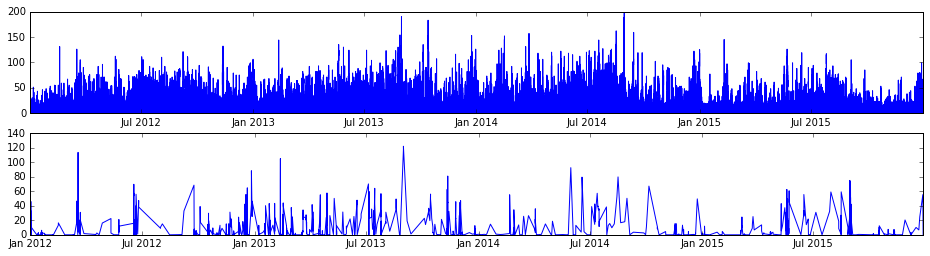

In [70]:
plt.figure(figsize=(16,4))
plt.subplot(211)
plt.plot(y_train)
plt.subplot(212)
plt.plot(y_test);

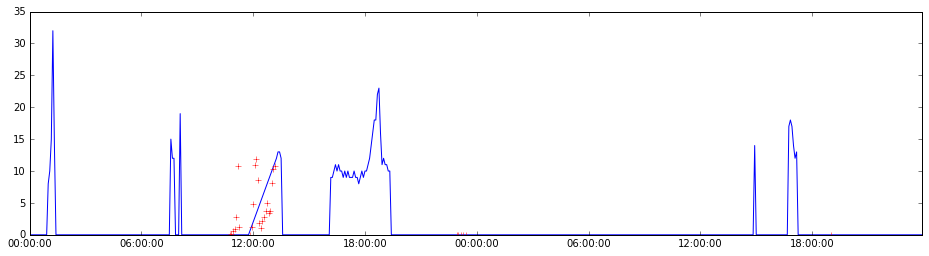

In [84]:
start = '2015-1-4'
end = '2015-1-6'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

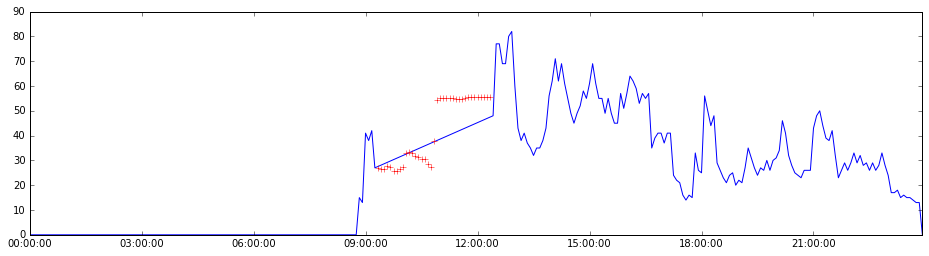

In [77]:
start = '2015-6-15'
end = '2015-6-16'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

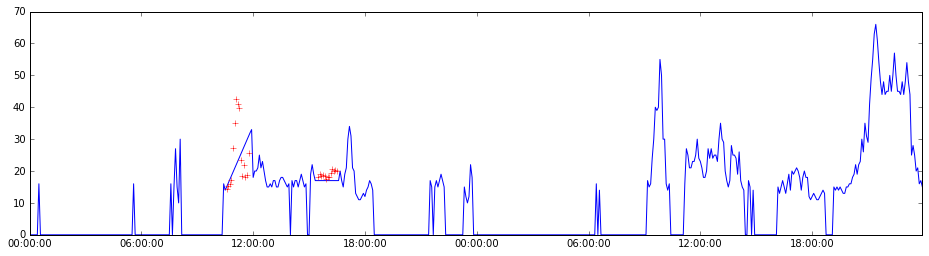

In [80]:
start = '2014-7-9'
end = '2014-7-11'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

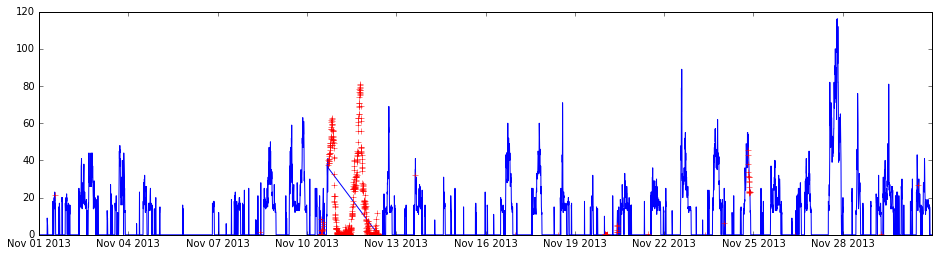

In [81]:
start = '2013-11-1'
end = '2013-12-1'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

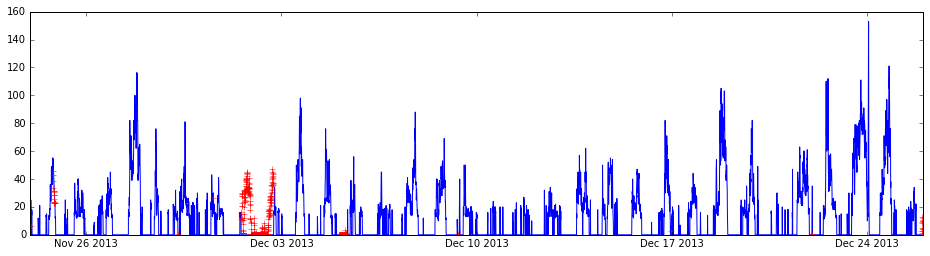

In [82]:
start = '2013-11-24'
end = '2013-12-26'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

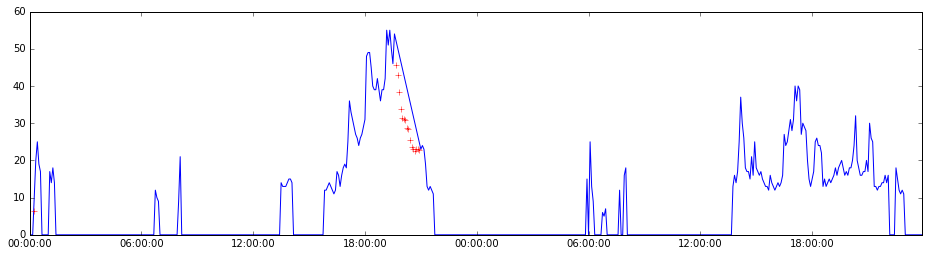

In [85]:
start = '2013-11-24'
end = '2013-11-26'
plt.figure(figsize=(16,4))
plt.plot(y_train[(y_train.index >= start) & (y_train.index < end)])
plt.plot(y_test[(y_test.index >= start) & (y_test.index < end)], 'r+');

## Missing data tends to be in clusters which does not help the false zero issue